# Set up

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import pandas as pd
import numpy as np
import typing
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
!pip install --upgrade keras
from keras import layers
from keras import ops

In [2]:
# url = "https://raw.githubusercontent.com/Nathathaii/wildfire-gnn/main/datasets/dataWTempV2.csv"
url = "https://raw.githubusercontent.com/Nathathaii/wildfire-gnn/main/datasets/dataV.6.csv"


# Load the CSV file into a DataFrame
df = pd.read_csv(url)

# Display the first few rows of the DataFrame
print(df.head())

   Unnamed: 0 Initialdate    Area_Km2 CountryName Continent           Region  \
0           0  2022-01-01  103.705298        Mali    Africa   Western Africa   
1       14600  2022-01-01    0.000000      Greece    Europe  Southern Europe   
2       26280  2022-01-01    0.000000     Hungary    Europe   Eastern Europe   
3       14965  2022-01-01    0.000000      Bhutan      Asia    Southern Asia   
4       25915  2022-01-01    5.342779      Guyana  Americas    South America   

   start_Area_Km2  end_Area_Km2       TEMP        SLP  ...  isBurn  \
0      103.705298     13.899566  78.375000  9999.9000  ...       1   
1        0.000000      0.000000  52.854170  7006.7270  ...       0   
2        0.000000      0.000000  46.889187  3449.5703  ...       0   
3        0.000000      0.000000  41.300000  9999.9000  ...       0   
4        5.342779      0.000000  79.500000  5506.4004  ...       1   

   Area_Km2_category  lag_TEMP   lag_SLP  lag_VISIB  lag_WDSP   lag_MXSPD  \
0               High 

In [3]:
column_names = df.columns.tolist()

print("Column names:")
for column in column_names:
    print(column)

Column names:
Unnamed: 0
Initialdate
Area_Km2
CountryName
Continent
Region
start_Area_Km2
end_Area_Km2
TEMP
SLP
VISIB
WDSP
MXSPD
GUST
MAX
MIN
year
month
day_of_week
day
isBurn
Area_Km2_category
lag_TEMP
lag_SLP
lag_VISIB
lag_WDSP
lag_MXSPD
lag_GUST
lag_MAX
lag_MIN


In [4]:
# Group the DataFrame by the 'Continent' column
continent_groups = df.groupby('Continent')

# Iterate over each continent group
for continent, group_df in continent_groups:
    print("Continent:", continent)
    # Get unique countries and regions in the continent group
    unique_countries = group_df['CountryName'].unique()
    unique_regions = group_df['Region'].unique()
    print("Countries:", unique_countries)
    print("Regions:", unique_regions)
    print()

Continent: Africa
Countries: ['Mali' 'Central African Republic' 'Sierra Leone' 'Sudan' 'Eritrea'
 'Zambia' 'Angola' 'Mauritania' 'Togo' 'Liberia' "Côte d'Ivoire" 'Kenya'
 'Rwanda' 'Ilemi Triangle' 'Comoros' 'Gabon' 'Egypt' 'Guinea-Bissau'
 'Madagascar' 'Namibia' 'Swaziland' 'United Republic of Tanzania' 'Guinea'
 'Mozambique' 'Tunisia' 'Malawi' 'Zimbabwe' 'Ethiopia' 'Botswana'
 'Somalia' 'Abyei' 'South Sudan' 'Congo' 'Burkina Faso' 'South Africa'
 'Senegal' 'Lesotho' 'Chad' 'Niger' 'Gambia' 'Benin' 'Uganda' 'Cameroon'
 'Morocco' 'Ghana' 'Nigeria' 'Algeria' 'Democratic Republic of the Congo'
 'Burundi']
Regions: ['Western Africa' 'Middle Africa' 'Northern Africa' 'Eastern Africa'
 'Southern Africa']

Continent: Americas
Countries: ['Guyana' 'Colombia' 'Ecuador' 'Suriname' 'Peru' 'Panama' 'Cuba' 'Uruguay'
 'Argentina' 'Chile' 'Jamaica' 'Haiti' 'Nicaragua' 'El Salvador'
 'French Guiana' 'Mexico' 'Bolivia' 'Bahamas' 'Brazil' 'Paraguay'
 'Dominican Republic' 'United States of America' 'Cost

# Create weight matrix
Note: high weight value means not relate (far distance)


same country = 0

same region = 0.2

same continent = 0.5

different continent = 1

In [294]:
one_day_df = df[:148]

# Get unique values for CountryName, Region, and Continent
unique_countries = one_day_df['CountryName'].unique()
unique_regions = one_day_df['Region'].unique()
unique_continents = one_day_df['Continent'].unique()

# Initialize weight matrix
num_countries = len(unique_countries)
weight_matrix = np.zeros((num_countries, num_countries))

# Iterate through each row of the DataFrame
for i, row1 in one_day_df.iterrows():
    for j, row2 in one_day_df.iterrows():
        # Calculate weight based on conditions
        if row1['CountryName'] == row2['CountryName']:
            weight = 0
        elif row1['Region'] == row2['Region']:
            weight = 0.2
        elif row1['Continent'] == row2['Continent']:
            weight = 0.5
        else:
            weight = 1

        # Assign weight to the corresponding position in the weight matrix
        weight_matrix[i, j] = weight

# Print the weight matrix
print(weight_matrix)
print(weight_matrix.shape)

[[0.  1.  1.  ... 1.  1.  1. ]
 [1.  0.  0.5 ... 1.  1.  1. ]
 [1.  0.5 0.  ... 1.  1.  1. ]
 ...
 [1.  1.  1.  ... 0.  1.  1. ]
 [1.  1.  1.  ... 1.  0.  0.5]
 [1.  1.  1.  ... 1.  0.5 0. ]]
(148, 148)


# Create Adjacency matrix

In [295]:
#boolean matrix (value 1 in the matrix = adjacent)
adjacency_matrix = (weight_matrix != 1).astype(int)

In [296]:
print(adjacency_matrix)
print(adjacency_matrix.shape)

[[1 0 0 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 1]
 [0 0 0 ... 0 1 1]]
(148, 148)


In [297]:
#load adjacency matrix assign from adjacenced countries
adjacent_url = "https://raw.githubusercontent.com/Nathathaii/wildfire-gnn/main/datasets/adjacency_matrix_sym.csv"


# Load the CSV file into a DataFrame
adjacency_df = pd.read_csv(adjacent_url, index_col=0)
adjacency_matrix_sym = adjacency_df.to_numpy()

# Print the adjacency matrix
print(adjacency_matrix_sym)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [298]:
print(adjacency_matrix_sym[0])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]


###Uncomment code below to use contry adjacency as adjacency matrix

In [299]:
#use adjacency matrix sym
# adjacency_matrix = adjacency_matrix_sym

In [300]:
class GraphInfo:
    def __init__(self, edges: typing.Tuple[list, list], num_nodes: int):
        self.edges = edges
        self.num_nodes = num_nodes
    def get_config(self):
        return {
            'edges': self.edges,
            'num_nodes': self.num_nodes
        }

node_indices, neighbor_indices = np.where(adjacency_matrix == 1)
graph = GraphInfo(
    edges=(node_indices.tolist(), neighbor_indices.tolist()),
    num_nodes=adjacency_matrix.shape[0],
)
print(f"number of nodes: {graph.num_nodes}, number of edges: {len(graph.edges[0])}")


number of nodes: 148, number of edges: 5486


# Create Value matrix
node = 148 countries

9 features = Area_Km2,TEMP,SLP,VISIB,WDSP,MXSPD,GUST,MAX,MIN


train data = January-August (242 days)

val data = September-October (61 days)

test data = November-December (62 days)

### Normalize features

In [301]:
def feature_1_year(feature):
  num_chunks = len(df) // 148

  # Initialize an empty array to store the extracted features
  features_array = np.empty((0, 148))

  # Iterate through each chunk
  for i in range(num_chunks):
      start_index = i * 148
      end_index = (i + 1) * 148
      # Extract the "TEMP" feature for the current chunk and append it to the features array
      temp_chunk = df.iloc[start_index:end_index][feature].values
      features_array = np.vstack((features_array, temp_chunk))

  # print(features_array.shape) -> (365, 148)
  return features_array


In [302]:
def preprocess(data_array, train_size, val_size, test_size):
  train_array = data_array[:train_size]
  mean, std = train_array.mean(axis=0), train_array.std(axis=0)

  train_array = (train_array - mean) / std
  val_array = (data_array[train_size : (train_size + val_size)] - mean) / std
  test_array = (data_array[(train_size + val_size) :] - mean) / std

  return mean, std, train_array, val_array, test_array


In [303]:
def invert_normalization(normalized_value, mean, std):
    return normalized_value * std + mean

### Add 1 more feature (difference between today area and yester area)

In [304]:
df.loc[:, f"lag_Area_Km2_1"] = df.copy().groupby('CountryName')['Area_Km2'].shift(1)
df=df.fillna(0)
for _,group_df in df.groupby('CountryName'):
    df.loc[group_df.index, 'diff_area'] = group_df['Area_Km2'] - group_df['lag_Area_Km2_1']

In [305]:
print(df.head())

   Unnamed: 0 Initialdate    Area_Km2 CountryName Continent           Region  \
0           0  2022-01-01  103.705298        Mali    Africa   Western Africa   
1       14600  2022-01-01    0.000000      Greece    Europe  Southern Europe   
2       26280  2022-01-01    0.000000     Hungary    Europe   Eastern Europe   
3       14965  2022-01-01    0.000000      Bhutan      Asia    Southern Asia   
4       25915  2022-01-01    5.342779      Guyana  Americas    South America   

   start_Area_Km2  end_Area_Km2       TEMP        SLP  ...  lag_TEMP  \
0      103.705298     13.899566  78.375000  9999.9000  ...      78.1   
1        0.000000      0.000000  52.854170  7006.7270  ...      78.1   
2        0.000000      0.000000  46.889187  3449.5703  ...      78.1   
3        0.000000      0.000000  41.300000  9999.9000  ...      78.1   
4        5.342779      0.000000  79.500000  5506.4004  ...      78.1   

    lag_SLP  lag_VISIB  lag_WDSP   lag_MXSPD  lag_GUST  lag_MAX  lag_MIN  \
0  9999.89

In [306]:
# features = ['Area_Km2','diff_area','lag_Area_Km2_1','TEMP','SLP','VISIB','WDSP','MXSPD','GUST','MAX','MIN']
# features = ['Area_Km2','diff_area','lag_Area_Km2_1','start_Area_Km2','end_Area_Km2','TEMP','SLP','VISIB','WDSP','MXSPD','GUST','MAX','MIN','isBurn','lag_TEMP','lag_SLP','lag_VISIB','lag_WDSP','lag_MXSPD','lag_GUST']
features = ['Area_Km2','diff_area','lag_Area_Km2_1']

# features = ['Area_Km2','diff_area','lag_Area_Km2_1','start_Area_Km2','end_Area_Km2','TEMP','SLP','VISIB','WDSP','MXSPD','GUST','MAX','MIN','year','month','day_of_week','day','isBurn','lag_TEMP','lag_SLP','lag_VISIB','lag_WDSP','lag_MXSPD','lag_GUST','lag_MAX','lag_MIN']
train_size = 242
val_size = 61
test_size = 62

features_train_array = []
features_val_array = []
features_test_array = []
features_mean_std = []

for feature in features:
  feature_array = feature_1_year(feature)
  mean, std, train_array, val_array, test_array = preprocess(feature_array, train_size, val_size, test_size)
  features_mean_std.append([mean,std])
  features_train_array.append(train_array)
  features_val_array.append(val_array)
  features_test_array.append(test_array)

features_train_array = np.stack(features_train_array, axis=-1)
features_val_array = np.stack(features_val_array, axis=-1)
features_test_array = np.stack(features_test_array, axis=-1)

print(features_train_array.shape)
print(features_val_array.shape)
print(features_test_array.shape)
print(len(features_mean_std))


(242, 148, 3)
(61, 148, 3)
(62, 148, 3)
3


In [307]:
print(features_train_array[0,0])

[-0.20980517  0.4287722  -0.24500346]


# Try only 1 feature (Area_Km2)

In [308]:
area_train_array = features_train_array[:,:,0]
area_val_array = features_val_array[:,:,0]
area_test_array = features_test_array[:,:,0]

print(area_train_array.shape)
print(area_val_array.shape)
print(area_test_array.shape)

(242, 148)
(61, 148)
(62, 148)


# Create Tensorflow Datasetes

In [309]:
batch_size = 8
input_sequence_length = 8
forecast_horizon = 3
multi_horizon = False


def create_tf_dataset(
    data_array: np.ndarray,
    input_sequence_length: int,
    forecast_horizon: int,
    batch_size: int = 8,
    shuffle=True,
    multi_horizon=True,
):
    """Creates tensorflow dataset from numpy array.

    This function creates a dataset where each element is a tuple `(inputs, targets)`.
    `inputs` is a Tensor
    of shape `(batch_size, input_sequence_length, num_routes, 1)` containing
    the `input_sequence_length` past values of the timeseries for each node.
    `targets` is a Tensor of shape `(batch_size, forecast_horizon, num_routes)`
    containing the `forecast_horizon`
    future values of the timeseries for each node.

    Args:
        data_array: np.ndarray with shape `(num_time_steps, num_routes)`
        input_sequence_length: Length of the input sequence (in number of timesteps).
        forecast_horizon: If `multi_horizon=True`, the target will be the values of the timeseries for 1 to
            `forecast_horizon` timesteps ahead. If `multi_horizon=False`, the target will be the value of the
            timeseries `forecast_horizon` steps ahead (only one value).
        batch_size: Number of timeseries samples in each batch.
        shuffle: Whether to shuffle output samples, or instead draw them in chronological order.
        multi_horizon: See `forecast_horizon`.

    Returns:
        A tf.data.Dataset instance.
    """

    inputs = keras.utils.timeseries_dataset_from_array(
        np.expand_dims(data_array[:-forecast_horizon], axis=-1),
        None,
        sequence_length=input_sequence_length,
        shuffle=False,
        batch_size=batch_size,
    )

    target_offset = (
        input_sequence_length
        if multi_horizon
        else input_sequence_length + forecast_horizon - 1
    )
    target_seq_length = forecast_horizon if multi_horizon else 1
    targets = keras.utils.timeseries_dataset_from_array(
        data_array[target_offset:],
        None,
        sequence_length=target_seq_length,
        shuffle=False,
        batch_size=batch_size,
    )

    dataset = tf.data.Dataset.zip((inputs, targets))
    if shuffle:
        dataset = dataset.shuffle(100)

    return dataset.prefetch(16).cache()

#create dataset

train_dataset, val_dataset = (
    create_tf_dataset(data_array, input_sequence_length, forecast_horizon, batch_size)
    for data_array in [features_train_array, features_val_array]
)

test_dataset = create_tf_dataset(
    features_test_array,
    input_sequence_length,
    forecast_horizon,
    batch_size=test_array.shape[0],
    shuffle=False,
    multi_horizon=multi_horizon,
)


In [310]:
#create dataset for 1 feature (area)
area_train_dataset, area_val_dataset = (
    create_tf_dataset(data_array, input_sequence_length, forecast_horizon, batch_size)
    for data_array in [area_train_array, area_val_array]
)

area_test_dataset = create_tf_dataset(
    area_test_array,
    input_sequence_length,
    forecast_horizon,
    batch_size=test_array.shape[0],
    shuffle=False,
    multi_horizon=multi_horizon,
)

In [311]:
train_dataset = train_dataset.map(lambda x, y: (tf.squeeze(x, axis=-1), y))
val_dataset = val_dataset.map(lambda x, y: (tf.squeeze(x, axis=-1), y))
test_dataset = test_dataset.map(lambda x, y: (tf.squeeze(x, axis=-1), y))

train_dataset_shape = next(iter(train_dataset))[0].shape
val_dataset_shape = next(iter(val_dataset))[0].shape
test_dataset_shape = next(iter(test_dataset))[0].shape

print("Train dataset shape:", train_dataset_shape)
print("Validation dataset shape:", val_dataset_shape)
print("Test dataset shape:", test_dataset_shape)


Train dataset shape: (8, 8, 148, 3)
Validation dataset shape: (8, 8, 148, 3)
Test dataset shape: (52, 8, 148, 3)


In [312]:
#check shape of area dataset
area_train_shape = next(iter(area_train_dataset))[0].shape
area_val_shape = next(iter(area_val_dataset))[0].shape
area_test_shape = next(iter(area_test_dataset))[0].shape

print("Train dataset shape:", area_train_shape)
print("Validation dataset shape:", area_val_shape)
print("Test dataset shape:", area_test_shape)

Train dataset shape: (8, 8, 148, 1)
Validation dataset shape: (8, 8, 148, 1)
Test dataset shape: (52, 8, 148, 1)


# GNN module

In [313]:
@keras.saving.register_keras_serializable()
class GraphConv(layers.Layer):
    def __init__(
        self,
        in_feat,
        out_feat,
        graph_info: GraphInfo,
        aggregation_type="mean",
        combination_type="concat",
        activation: typing.Optional[str] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.graph_info = graph_info
        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.weight = self.add_weight(
            initializer=keras.initializers.GlorotUniform(),
            shape=(in_feat, out_feat),
            dtype="float32",
            trainable=True,
        )
        self.activation = layers.Activation(activation)

    def aggregate(self, neighbour_representations):
        aggregation_func = {
            "sum": tf.math.unsorted_segment_sum,
            "mean": tf.math.unsorted_segment_mean,
            "max": tf.math.unsorted_segment_max,
        }.get(self.aggregation_type)

        if aggregation_func:
            return aggregation_func(
                neighbour_representations,
                self.graph_info.edges[0],
                num_segments=self.graph_info.num_nodes,
            )

        raise ValueError(f"Invalid aggregation type: {self.aggregation_type}")

    def compute_nodes_representation(self, features):
        """Computes each node's representation.

        The nodes' representations are obtained by multiplying the features tensor with
        `self.weight`. Note that
        `self.weight` has shape `(in_feat, out_feat)`.

        Args:
            features: Tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        print(f"feature shape={features.shape}, weight shape = {self.weight.shape}")
        return ops.matmul(features, self.weight)

    def compute_aggregated_messages(self, features):
        neighbour_representations = tf.gather(features, self.graph_info.edges[1])
        aggregated_messages = self.aggregate(neighbour_representations)
        return ops.matmul(aggregated_messages, self.weight)

    def update(self, nodes_representation, aggregated_messages):
        if self.combination_type == "concat":
            h = ops.concatenate([nodes_representation, aggregated_messages], axis=-1)
        elif self.combination_type == "add":
            h = nodes_representation + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        return self.activation(h)

    def call(self, features):
        """Forward pass.

        Args:
            features: tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        print(f"feature shape={len(feature)}")
        nodes_representation = self.compute_nodes_representation(features)
        aggregated_messages = self.compute_aggregated_messages(features)
        return self.update(nodes_representation, aggregated_messages)
    def get_config(self):
        config = super().get_config()
        config.update({
            'in_feat': self.in_feat,
            'out_feat': self.out_feat,
            'graph_info': self.graph_info,
            'aggregation_type': self.aggregation_type,
            'combination_type': self.combination_type,
            'activation': self.activation,
        })
        return config


In [314]:
@keras.saving.register_keras_serializable()
class GraphConv2(layers.Layer):
    def __init__(
        self,
        in_feat,
        out_feat,
        graph_info: GraphInfo,
        aggregation_type="mean",
        combination_type="concat",
        activation: typing.Optional[str] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.graph_info = graph_info
        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.weight = self.add_weight(
            initializer=keras.initializers.GlorotUniform(),
            shape=(in_feat*2, out_feat),
            dtype="float32",
            trainable=True,
        )
        self.activation = layers.Activation(activation)

    def aggregate(self, neighbour_representations):
        aggregation_func = {
            "sum": tf.math.unsorted_segment_sum,
            "mean": tf.math.unsorted_segment_mean,
            "max": tf.math.unsorted_segment_max,
        }.get(self.aggregation_type)

        if aggregation_func:
            return aggregation_func(
                neighbour_representations,
                self.graph_info.edges[0],
                num_segments=self.graph_info.num_nodes,
            )

        raise ValueError(f"Invalid aggregation type: {self.aggregation_type}")

    def compute_nodes_representation(self, features):
        """Computes each node's representation.

        The nodes' representations are obtained by multiplying the features tensor with
        `self.weight`. Note that
        `self.weight` has shape `(in_feat, out_feat)`.

        Args:
            features: Tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        print(f"feature shape={features.shape}, weight shape = {self.weight.shape}")
        return ops.matmul(features, self.weight)

    def compute_aggregated_messages(self, features):
        neighbour_representations = tf.gather(features, self.graph_info.edges[1])
        aggregated_messages = self.aggregate(neighbour_representations)
        return ops.matmul(aggregated_messages, self.weight)

    def update(self, nodes_representation, aggregated_messages):
        if self.combination_type == "concat":
            h = ops.concatenate([nodes_representation, aggregated_messages], axis=-1)
        elif self.combination_type == "add":
            h = nodes_representation + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        return self.activation(h)

    def call(self, features):
        """Forward pass.

        Args:
            features: tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        print(f"feature shape={len(feature)}")
        nodes_representation = self.compute_nodes_representation(features)
        aggregated_messages = self.compute_aggregated_messages(features)
        return self.update(nodes_representation, aggregated_messages)
    def get_config(self):
        config = super().get_config()
        config.update({
            'in_feat': self.in_feat,
            'out_feat': self.out_feat,
            'graph_info': self.graph_info,
            'aggregation_type': self.aggregation_type,
            'combination_type': self.combination_type,
            'activation': self.activation,
        })
        return config


# LSTM module

In [315]:
# @keras.saving.register_keras_serializable()
# class LSTMGC(layers.Layer):
#     """Layer comprising a convolution layer followed by LSTM and dense layers."""

#     def __init__(
#         self,
#         in_feat,
#         out_feat,
#         lstm_units: int,
#         input_seq_len: int,
#         output_seq_len: int,
#         graph_info: GraphInfo,
#         graph_conv_params: typing.Optional[dict] = None,
#         **kwargs,
#     ):
#         super().__init__(**kwargs)

#         # graph conv layer
#         if graph_conv_params is None:
#             graph_conv_params = {
#                 "aggregation_type": "mean",
#                 "combination_type": "concat",
#                 "activation": None,
#             }
#         self.graph_conv = GraphConv(in_feat, out_feat, graph_info, **graph_conv_params)
#         self.graph_conv_params = graph_conv_params
#         self.lstm = layers.LSTM(lstm_units, activation="relu", input_shape=(input_seq_len, in_feat))
#         self.dense = layers.Dense(output_seq_len * in_feat)
#         self.graph_info = graph_info
#         self.lstm_units = lstm_units
#         self.input_seq_len, self.output_seq_len = input_seq_len, output_seq_len
#         self.in_feat = in_feat
#         self.out_feat = out_feat
#     def build(self, input_shape):
#         num_nodes, batch_size, input_seq_len, in_feat = input_shape

#         if self.graph_conv_params is None:
#             self.graph_conv_params = {
#                 "aggregation_type": "mean",
#                 "combination_type": "concat",
#                 "activation": None,
#             }

#         self.graph_conv = GraphConv(
#             in_feat,
#             self.out_feat,
#             self.graph_info,
#             **self.graph_conv_params
#         )

#         self.lstm = layers.LSTM(
#             self.lstm_units,
#             activation="relu",
#             input_shape=(input_seq_len, self.out_feat)
#         )

#         self.dense = layers.Dense(self.output_seq_len * in_feat)

#         super().build(input_shape)

#     def call(self, inputs):
#         """Forward pass.

#         Args:
#             inputs: tensor of shape `(batch_size, input_seq_len, num_nodes, in_feat)`

#         Returns:
#             A tensor of shape `(batch_size, output_seq_len, num_nodes)`.
#         """

#         # convert shape to  (num_nodes, batch_size, input_seq_len, in_feat)
#         print("Input shape:", inputs.shape)
#         inputs = ops.transpose(inputs, [2, 0, 1, 3])

#         gcn_out = self.graph_conv(
#             inputs
#         )  # gcn_out has shape: (num_nodes, batch_size, input_seq_len, out_feat)

#         shape = ops.shape(gcn_out)
#         print("gcn out shape = ",gcn_out.shape)
#         num_nodes, batch_size, input_seq_len, out_feat = (
#             shape[0],
#             shape[1],
#             shape[2],
#             shape[3],
#         )

#         # LSTM takes only 3D tensors as input
#         gcn_out = ops.reshape(
#             gcn_out, (batch_size * num_nodes, input_seq_len, out_feat)
#         )

#         lstm_out = self.lstm(
#             gcn_out
#         )  # lstm_out has shape: (batch_size * num_nodes, lstm_units)

#         dense_output = self.dense(
#             lstm_out
#         )  # dense_output has shape: (batch_size * num_nodes, output_seq_len, features)
#         output = ops.reshape(dense_output, (num_nodes, batch_size, self.output_seq_len,self.in_feat))
#         return ops.transpose(
#             output, [1, 2, 0, 3]
#         )  # returns Tensor of shape (batch_size, output_seq_len, num_nodes,features)

#     def get_config(self):
#         config = super().get_config()
#         config.update({
#             'in_feat': self.in_feat,
#             'out_feat': self.out_feat,
#             'lstm_units': self.lstm_units,
#             'input_seq_len': self.input_seq_len,
#             'output_seq_len': self.output_seq_len,
#             'graph_info': self.graph_info,
#             'graph_conv_params': self.graph_conv_params
#         })
#         return config

In [316]:
@tf.keras.utils.register_keras_serializable()
class LSTMGC(layers.Layer):
    def __init__(
        self,
        in_feat,
        out_feat,
        lstm_units: int,
        input_seq_len: int,
        output_seq_len: int,
        graph_info: GraphInfo,
        graph_conv_params: typing.Optional[dict] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)

        if graph_conv_params is None:
            graph_conv_params = {
                "aggregation_type": "mean",
                "combination_type": "concat",
                "activation": None,
            }

        self.graph_conv1 = GraphConv(in_feat, out_feat, graph_info, **graph_conv_params)
        self.graph_conv2 = GraphConv2(out_feat, out_feat, graph_info, **graph_conv_params)
        self.graph_conv_params = graph_conv_params
        self.lstm = layers.LSTM(lstm_units, activation="relu", input_shape=(input_seq_len, out_feat))
        self.dense = layers.Dense(output_seq_len * in_feat)
        self.graph_info = graph_info
        self.lstm_units = lstm_units
        self.input_seq_len, self.output_seq_len = input_seq_len, output_seq_len
        self.in_feat = in_feat
        self.out_feat = out_feat

    def build(self, input_shape):
        num_nodes, batch_size, input_seq_len, in_feat = input_shape

        if self.graph_conv_params is None:
            self.graph_conv_params = {
                "aggregation_type": "mean",
                "combination_type": "concat",
                "activation": None,
            }

        self.graph_conv1 = GraphConv(
            self.in_feat,
            self.out_feat,
            self.graph_info,
            **self.graph_conv_params
        )
        self.graph_conv2 = GraphConv2(
            self.out_feat,
            self.out_feat,
            self.graph_info,
            **self.graph_conv_params
        )

        self.lstm = layers.LSTM(
            self.lstm_units,
            activation="relu",
            input_shape=(input_seq_len, self.out_feat)
        )

        self.dense = layers.Dense(self.output_seq_len * self.in_feat)

        super().build(input_shape)

    def call(self, inputs):
        print("Input shape:", inputs.shape)
        inputs = tf.transpose(inputs, [2, 0, 1, 3])

        gcn_out1 = self.graph_conv1(inputs)

        print(f"gcn_out1 shape={gcn_out1.shape}")
        gcn_out2 = self.graph_conv2(gcn_out1)

        shape = ops.shape(gcn_out2)
        print("gcn out shape = ", gcn_out2.shape)
        num_nodes, batch_size, input_seq_len, out_feat = (
            shape[0],
            shape[1],
            shape[2],
            shape[3],
        )

        gcn_out2 = ops.reshape(
            gcn_out2, (batch_size * num_nodes, input_seq_len, out_feat)
        )

        lstm_out = self.lstm(gcn_out2)

        dense_output = self.dense(lstm_out)
        output = ops.reshape(dense_output, (num_nodes, batch_size, self.output_seq_len,self.in_feat))
        return ops.transpose(
            output, [1, 2, 0, 3]
        )  # returns Tensor of shape (batch_size, output_seq_len, num_nodes,features)
    def get_config(self):
        config = super().get_config()
        config.update({
            'in_feat': self.in_feat,
            'out_feat': self.out_feat,
            'lstm_units': self.lstm_units,
            'input_seq_len': self.input_seq_len,
            'output_seq_len': self.output_seq_len,
            'graph_info': self.graph_info,
            'graph_conv_params': self.graph_conv_params
        })
        return config


In [317]:
def custom_mean_squared_error(y_true, y_pred):
    # Reshape y_pred to match the shape of y_true
    print("loss")
    print("y_true", y_true.shape)
    print("y_pred", y_pred.shape)
    # y_true = tf.reshape(y_true[:,:,:,0], (-1, 3, 148))
    # Compute mean squared error
    return tf.reduce_mean(tf.square(y_true - y_pred))

# Train all features GNN + LSTM

In [318]:
from google.colab import drive
from keras.callbacks import ModelCheckpoint

drive.mount('/content/drive')
filepath = '/content/drive/My Drive/GNN_best_model.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True, mode='min', verbose=1)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [340]:
in_feat = len(features)
batch_size =  8
epochs = 2000
input_sequence_length = 8
forecast_horizon = 3
multi_horizon = False
out_feat = 10
lstm_units = 8
lr = 0.0002
# lr = 0.001

graph_conv_params = {
    "aggregation_type": "mean",
    "combination_type": "concat",
    "activation": None,
}

st_gcn = LSTMGC(
    in_feat,
    out_feat,
    lstm_units,
    input_sequence_length,
    forecast_horizon,
    graph,
    graph_conv_params
)
inputs = layers.Input((input_sequence_length, graph.num_nodes, in_feat))
outputs = st_gcn(inputs)

model = keras.models.Model(inputs, outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=lr),
    loss=custom_mean_squared_error,
)
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[checkpoint, keras.callbacks.EarlyStopping(patience=10)],
)

Input shape: (None, 8, 148, 3)
feature shape=14
feature shape=(148, None, 8, 3), weight shape = (3, 10)
feature shape=14
feature shape=(148, None, 8, 3), weight shape = (3, 10)
gcn_out1 shape=(148, None, 8, 20)
feature shape=14
feature shape=(148, None, 8, 20), weight shape = (20, 10)
feature shape=14
feature shape=(148, None, 8, 20), weight shape = (20, 10)
gcn out shape =  (148, None, 8, 20)
Epoch 1/2000
Input shape: (None, None, 148, 3)
feature shape=14
feature shape=(148, None, None, 3), weight shape = (3, 10)
gcn_out1 shape=(148, None, None, 20)
feature shape=14
feature shape=(148, None, None, 20), weight shape = (20, 10)
gcn out shape =  (148, None, None, 20)
loss
y_true (None, None, 148, 3)
y_pred (None, 3, 148, 3)


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['variable_140', 'variable_141'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Input shape: (None, None, 148, 3)
feature shape=14
feature shape=(148, None, None, 3), weight shape = (3, 10)
gcn_out1 shape=(148, None, None, 20)
feature shape=14
feature shape=(148, None, None, 20), weight shape = (20, 10)
gcn out shape =  (148, None, None, 20)
loss
y_true (None, None, 148, 3)
y_pred (None, 3, 148, 3)
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 1.2073Input shape: (None, None, 148, 3)
feature shape=14
feature shape=(148, None, None, 3), weight shape = (3, 10)
gcn_out1 shape=(148, None, None, 20)
feature shape=14
feature shape=(148, None, None, 20), weight shape = (20, 10)
gcn out shape =  (148, None, None, 20)
loss
y_true (None, None, 148, 3)
y_pred (None, 3, 148, 3)

Epoch 1: val_loss did not improve from 5.78633
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 1.2010 - val_loss: 5.8587
Epoch 2/2000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 1.2038
Epoch 2: val_loss did not improve from 5.78633
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 1.1975 - val_loss

In [341]:
model.summary()

Model: "functional_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_36 (InputLayer)          │ (None, 8, 148, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstmgc_36 (LSTMGC)                   │ (None, 3, 148, 3)           │           1,469 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,940 (11.49 KB)

 Trainable params: 1,469 (5.74 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,471 (5.75 KB)

## calculate MAE from all features accuracy

Input shape: (32, 8, 148, 3)
feature shape=14
feature shape=(148, 32, 8, 3), weight shape = (3, 10)
gcn_out1 shape=(148, 32, 8, 20)
feature shape=14
feature shape=(148, 32, 8, 20), weight shape = (20, 10)
gcn out shape =  (148, 32, 8, 20)
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/stepInput shape: (None, 8, 148, 3)
feature shape=14
feature shape=(148, None, 8, 3), weight shape = (3, 10)
gcn_out1 shape=(148, None, 8, 20)
feature shape=14
feature shape=(148, None, 8, 20), weight shape = (20, 10)
gcn out shape =  (148, None, 8, 20)
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 463ms/step
(52, 8, 148, 3)
(52, 1, 148, 3)
(52, 3, 148, 3)
naive MSE: 17.82539083062226, model MSE: 8.833387313455088
naive MAE: 0.8672445257762955, model MAE: 0.648246029397128


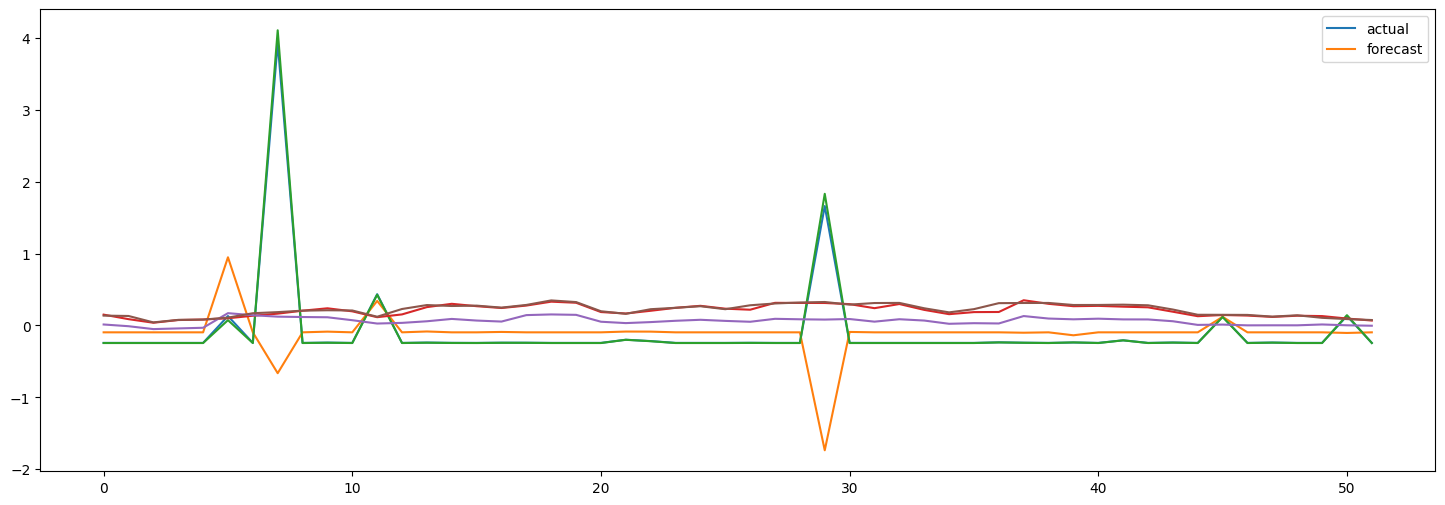

In [342]:
x_test, y = next(test_dataset.as_numpy_iterator())
y_pred = model.predict(x_test)
x_test = x_test[:, :, :, :]
print(x_test.shape)
print(y.shape)
print(y_pred.shape)
plt.figure(figsize=(18, 6))
plt.plot(y[:, 0, 0])
plt.plot(y_pred[:, 0, 0])
plt.legend(["actual", "forecast"])

naive_mse, model_mse = (
    np.square(x_test[:, -1, :, :] - y[:, 0, :]).mean(),
    np.square(y_pred[:, 0, :] - y[:, 0, :]).mean(),
)
naive_mae, model_mae = (
    np.abs(x_test[:, -1, :, :] - y[:, 0, :]).mean(),
    np.abs(y_pred[:, 0, :] - y[:, 0, :]).mean(),
)

print(f"naive MSE: {naive_mse}, model MSE: {model_mse}")
print(f"naive MAE: {naive_mae}, model MAE: {model_mae}")


In [343]:
keras.saving.save_model(model,"trained_model.keras")

## Plot loss

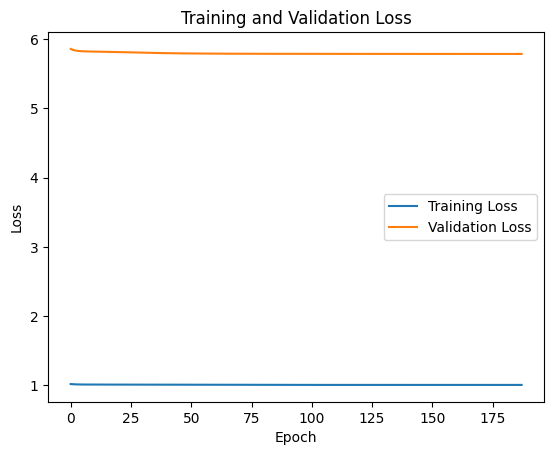

In [344]:
# Plot training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## See edge weight

In [345]:
# graph_conv_layer = st_gcn.graph_conv

# # Access the edge weights
# graph_weights = graph_conv_layer.weight.numpy()

# # Print the edge weights
# print("Graph Weights:")
# print(graph_weights)

# Visualize the graph

In [346]:
unique_regions = df['Region'].unique()
print(unique_regions)

['Western Africa' 'Southern Europe' 'Eastern Europe' 'Southern Asia'
 'South America' 'Middle Africa' 'Northern Europe' 'Western Asia'
 'Central Asia' 'Northern Africa' 'Eastern Africa' 'South-Eastern Asia'
 'Eastern Asia' 'Australia and New Zealand' 'Western Europe'
 'Central America' 'Caribbean' 'Melanesia' 'Southern Africa'
 'Northern America']


In [347]:
continent_colors = {
    'Western Africa': 'blue',
    'Southern Europe': 'green',
    'Eastern Europe': 'purple',
    'Southern Asia': 'red',
    'South America': 'orange',
    'Middle Africa': 'cyan',
    'Northern Europe': 'magenta',
    'Western Asia': 'yellow',
    'Central Asia': 'lime',
    'Northern Africa': 'pink',
    'Eastern Africa': 'skyblue',
    'South-Eastern Asia': 'gold',
    'Eastern Asia': 'lightcoral',
    'Australia and New Zealand': 'lightgreen',
    'Western Europe': 'teal',
    'Central America': 'lightpink',
    'Caribbean': 'lightblue',
    'Melanesia': 'lavender',
    'Southern Africa': 'lightyellow',
    'Northern America': 'lightgrey'
}

# Map each region to its corresponding color
region_colors = [continent_colors[region] for region in unique_regions]

In [348]:
print(region_colors)

['blue', 'green', 'purple', 'red', 'orange', 'cyan', 'magenta', 'yellow', 'lime', 'pink', 'skyblue', 'gold', 'lightcoral', 'lightgreen', 'teal', 'lightpink', 'lightblue', 'lavender', 'lightyellow', 'lightgrey']


In [349]:
one_day_df = df[:148]
country_colors = []
for region in one_day_df['Region']:
    country_colors.append(continent_colors[region])

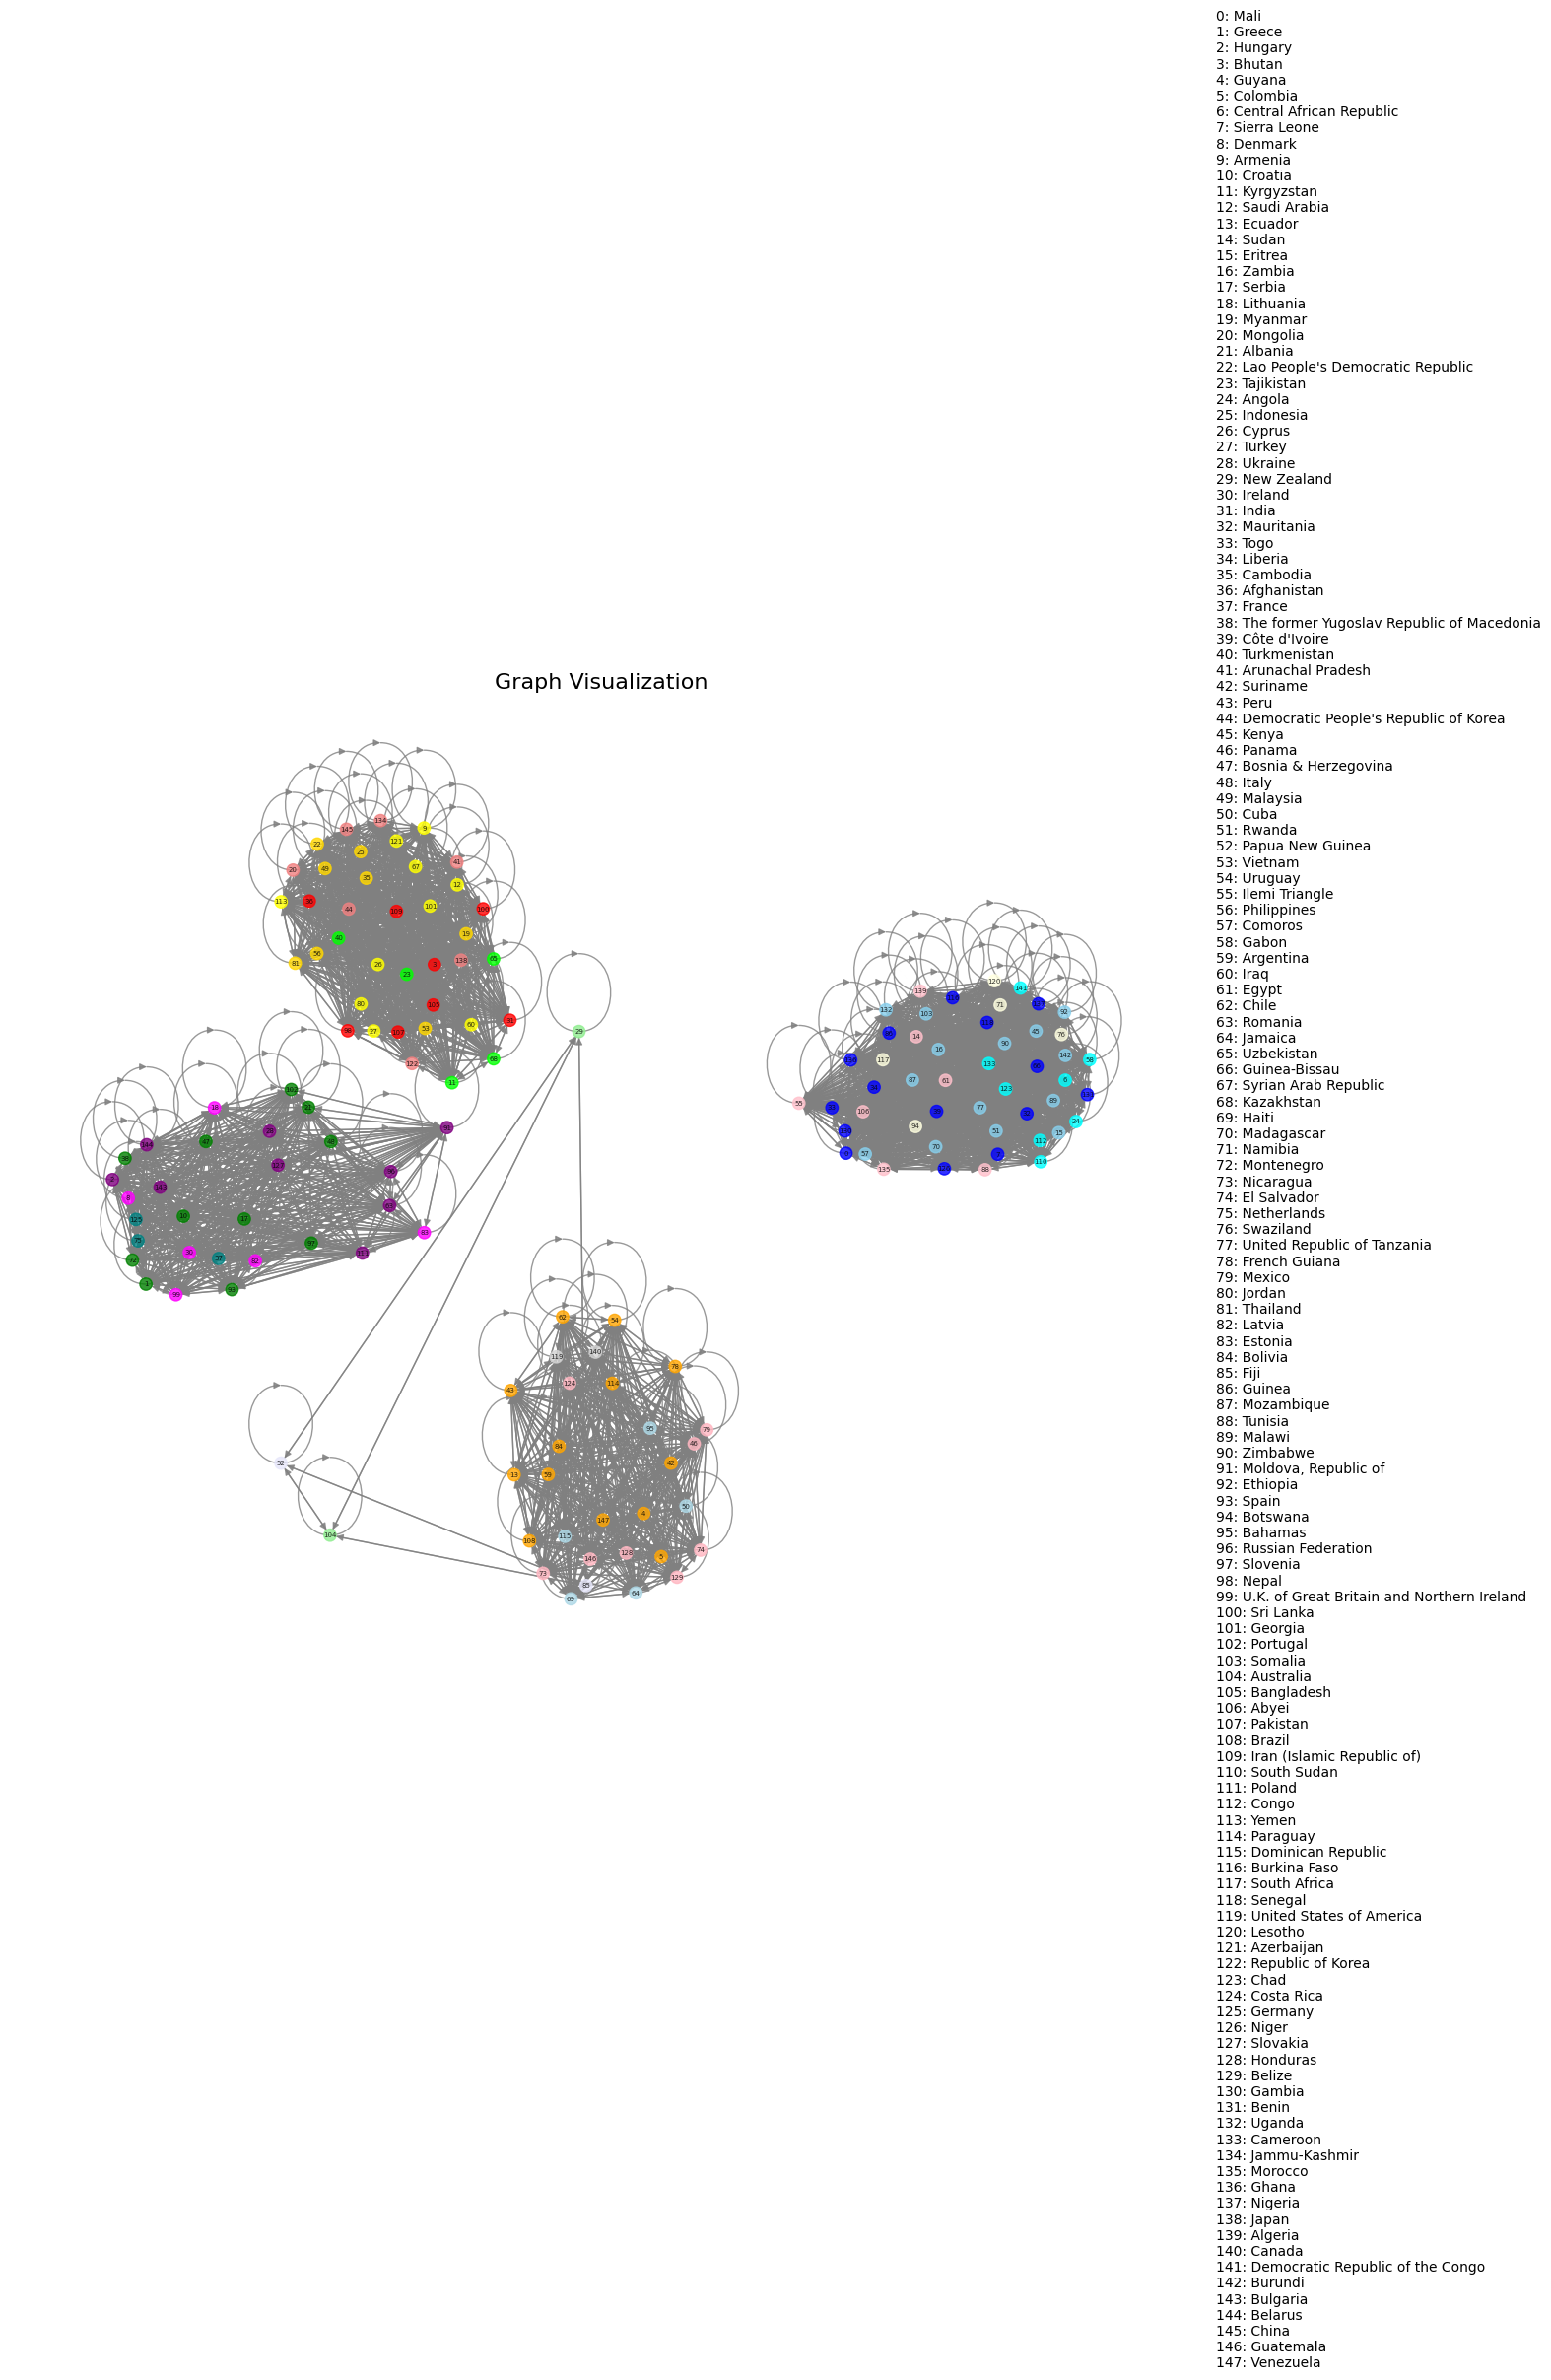

In [350]:
import networkx as nx
import matplotlib.pyplot as plt

# Assuming you have instantiated your GraphInfo object as graph

# Create a directed graph
G = nx.DiGraph()

# Add nodes to the graph
G.add_nodes_from(range(graph.num_nodes))

# Add edges to the graph
edges = list(zip(*graph.edges))
G.add_edges_from(edges)

unique_countries = one_day_df['CountryName'].unique()
node_country_mapping = {i: country for i, country in enumerate(unique_countries)}

# Define the layout for the graph (e.g., circular, spring, spectral, etc.)
# layout = nx.spring_layout(G)  # Adjust the k parameter as needed
layout = nx.spring_layout(G, k=0.80)  # Adjust the k parameter as needed

# Visualize the graph with custom styling
plt.figure(figsize=(12, 10))
nx.draw(
    G,
    pos=layout,
    with_labels=True,
    node_size=80,
    node_color=country_colors,
    edge_color="gray",
    font_size=5,
    font_weight="light",
    arrowsize=10,
    linewidths=1,
    alpha=0.8,
)

# Create legend or mapping between node numbers and country names
legend_text = "\n".join([f"{i}: {country}" for i, country in node_country_mapping.items()])
plt.text(1.02, 0.5, legend_text, transform=plt.gca().transAxes, fontsize=10, verticalalignment='center')


plt.title("Graph Visualization", fontsize=16)
plt.axis("off")  # Hide the axis
plt.show()


## Evaluation

In [351]:
def evaluate_feature(feature_ind, test_dataset, model, features_mean_std, country_ind):
    x_test, y = next(test_dataset.as_numpy_iterator())
    y_pred = model.predict(x_test)

    # Select only the specified feature
    x_test = x_test[:,:,:,feature_ind]
    y = y[:,:,:,feature_ind]
    y_pred = y_pred[:,:,:,feature_ind]

    print(x_test.shape)
    print(y.shape)
    print(y_pred.shape)

    # Invert normalized value
    area_mean, area_std = features_mean_std[feature_ind]
    x_test = invert_normalization(x_test, area_mean, area_std)
    y = invert_normalization(y, area_mean, area_std)
    y_pred = invert_normalization(y_pred, area_mean, area_std)
    # if(feature_ind == features.index('isBurn')):
    #   #make it binary with threshold = 0.5
    #   y_pred_binary = (y_pred > 0.5).astype(np.float32)
    #   y_pred = y_pred_binary

    #plot
    plt.figure(figsize=(18, 6))
    plt.plot(y[:, 0, country_ind])
    plt.plot(y_pred[:, 0, country_ind])
    plt.legend(["actual", "forecast"])

    # Calculate MSE and MAE
    naive_mse = np.square(x_test[:, -1, :] - y[:, 0, :]).mean()
    model_mse = np.square(y_pred[:, 0, :] - y[:, 0, :]).mean()

    naive_mae = np.abs(x_test[:, -1, :] - y[:, 0, :]).mean()
    model_mae = np.abs(y_pred[:, 0, :] - y[:, 0, :]).mean()

    # Calculate majority baseline
    majority_mse = np.square(0 - y[:, 0, :]).mean()
    majority_mae = np.abs(0 - y[:, 0, :]).mean()

    print(f"Model MSE: {model_mse}, Model MAE: {model_mae}")
    print(f"Naive MSE: {naive_mse}, Naive MAE: {naive_mae}")
    print(f"Majority MSE: {majority_mse}, Majority MAE: {majority_mae}\n")

    return naive_mse, model_mse, naive_mae, model_mae, majority_mse, majority_mae


## calculate MAE from area only

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
(52, 8, 148)
(52, 1, 148)
(52, 3, 148)
Model MSE: 78392726.5849573, Model MAE: 2613.593388141091
Naive MSE: 154357546.13683295, Naive MAE: 3052.6057170467875
Majority MSE: 80647311.32280003, Majority MAE: 1622.97930632526



(154357546.13683295,
 78392726.5849573,
 3052.6057170467875,
 2613.593388141091,
 80647311.32280003,
 1622.97930632526)

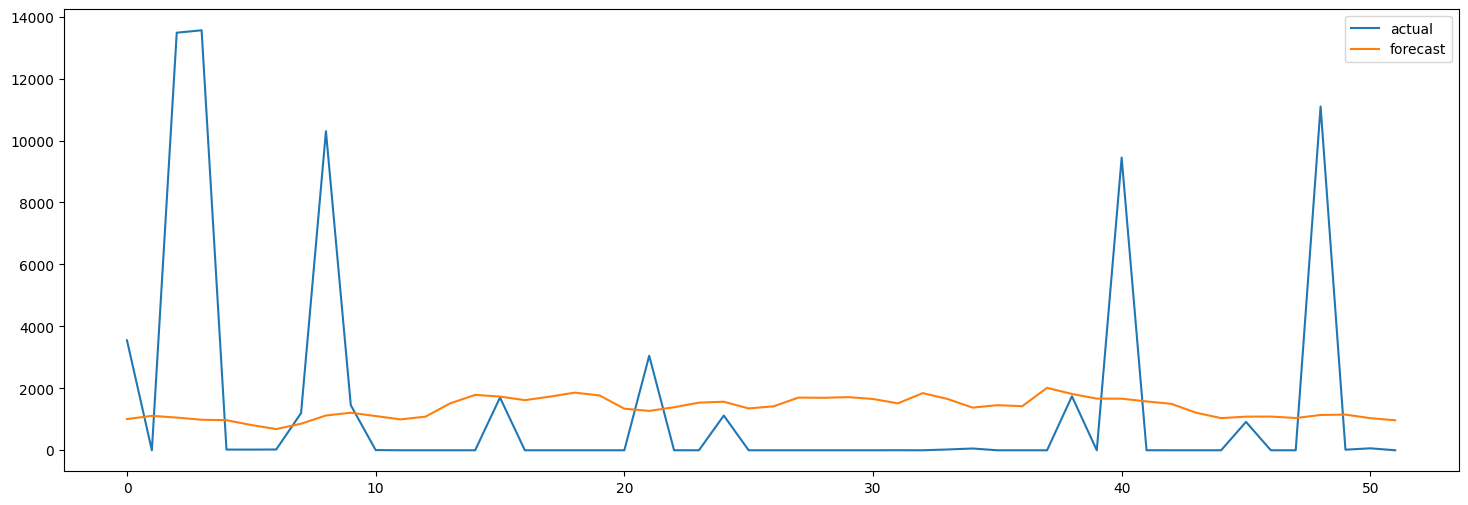

In [352]:
feature_ind = 0
country_ind = 70
evaluate_feature(feature_ind, test_dataset, model, features_mean_std, country_ind)

## calculate MAE for diff_area

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
(52, 8, 148)
(52, 1, 148)
(52, 3, 148)
Model MSE: 189092.45611750163, Model MAE: 79.21983221676751
Naive MSE: 867949.5996833739, Naive MAE: 130.23665356132497
Majority MSE: 187818.3890792404, Majority MAE: 62.18394523069686



(867949.5996833739,
 189092.45611750163,
 130.23665356132497,
 79.21983221676751,
 187818.3890792404,
 62.18394523069686)

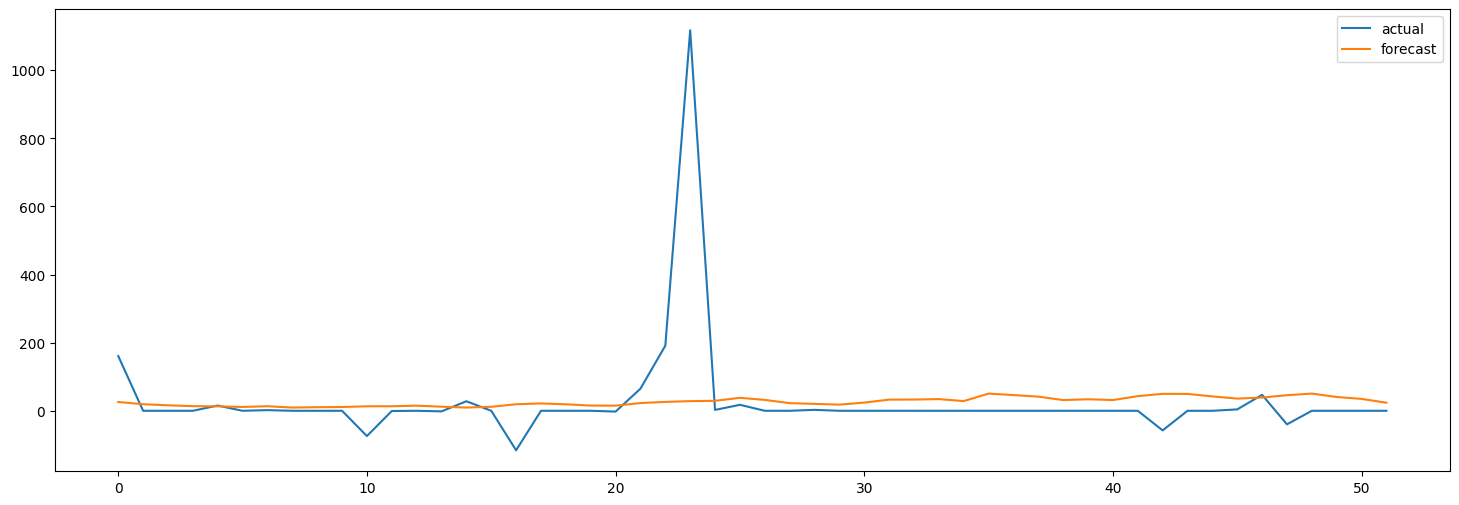

In [353]:
feature_ind = 1
country_ind = 2
evaluate_feature(feature_ind, test_dataset, model, features_mean_std, country_ind)

## calculate MAE for isBurn

In [282]:
feature_ind = features.index('isBurn')
country_ind = 3
evaluate_feature(feature_ind, test_dataset, model, features_mean_std, country_ind)

ValueError: 'isBurn' is not in list

## calculate MAE of area prediction from diff_area

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
(52, 8, 148)
(52, 1, 148)
(52, 3, 148, 3)
area_pred shape = (52, 148)
model MSE: 189064.96429703746, model MAE: 77.99563038465112
naive MSE: 187818.38907924044, naive MAE: 62.18394523069688
Majority MSE: 80647311.32280003, Majority MAE: 1622.97930632526



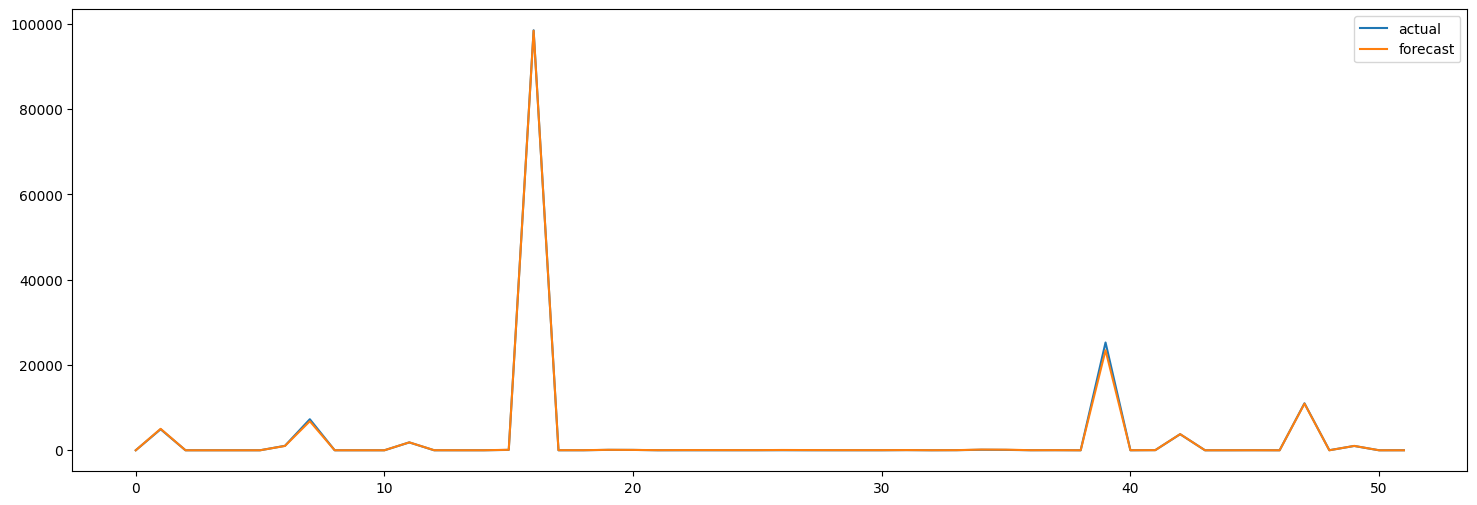

In [354]:
area_ind = 0
diff_area_ind = 1
lag_area_ind = 2
country_ind = 3

x_test, y_ans = next(test_dataset.as_numpy_iterator())
y_pred = model.predict(x_test)

# Select only the specified feature
x_test = x_test[:,:,:,area_ind]
y = y_ans[:,:,:,area_ind]
#predict area from diff_area
yesterday_area = y_ans[:,:,:,lag_area_ind]
diff_area_pred = y_pred[:,:,:,diff_area_ind]

print(x_test.shape)
print(y.shape)
print(y_pred.shape)

# Invert normalized value
area_mean, area_std = features_mean_std[area_ind]
diff_area_mean, diff_area_std = features_mean_std[diff_area_ind]
lag_area_mean, lag_area_std = features_mean_std[lag_area_ind]

x_test = invert_normalization(x_test, area_mean, area_std)
y = invert_normalization(y, area_mean, area_std)
#for y_pred
yesterday_area = invert_normalization(yesterday_area, lag_area_mean, lag_area_std)
diff_area_pred = invert_normalization(diff_area_pred, diff_area_mean, diff_area_std)
area_pred = yesterday_area[:, 0, :] + diff_area_pred[:, 0, :]
area_pred = np.maximum(area_pred, 0)
print(f"area_pred shape = {area_pred.shape}")

#plot
plt.figure(figsize=(18, 6))
plt.plot(y[:, 0, country_ind])
plt.plot(area_pred[:,country_ind])
plt.legend(["actual", "forecast"])

# Calculate MSE and MAE
naive_mse = np.square(yesterday_area[:, 0, :] - y[:, 0, :]).mean()
model_mse = np.square(area_pred - y[:, 0, :]).mean()

naive_mae = np.abs(yesterday_area[:, 0, :] - y[:, 0, :]).mean()
model_mae = np.abs(area_pred - y[:, 0, :]).mean()

# Calculate majority baseline
majority_mse = np.square(0 - y[:, 0, :]).mean()
majority_mae = np.abs(0 - y[:, 0, :]).mean()

print(f"model MSE: {model_mse}, model MAE: {model_mae}")
print(f"naive MSE: {naive_mse}, naive MAE: {naive_mae}")
print(f"Majority MSE: {majority_mse}, Majority MAE: {majority_mae}\n")


In [334]:
print(area_pred[:,country_ind])

[0.00000000e+00 5.03324224e+03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.23355575e+00 1.01999977e+03 6.77450904e+03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.85851147e+03
 8.32375710e+00 4.75085514e+00 1.63879929e+01 1.04256449e+02
 9.83254321e+04 1.82749262e+01 2.20633139e+01 8.52671386e+01
 9.11482791e+01 1.38178899e+01 1.29606016e+01 1.07819490e+01
 7.10330180e+00 1.79501144e+01 3.17715614e+01 1.56849473e+01
 7.78359592e+00 1.19055716e+01 1.01639318e+01 3.52750892e+01
 7.50254630e+00 2.46936042e+01 1.65164431e+02 1.34061516e+02
 1.58423085e+01 2.75611348e+01 5.93078641e+00 2.34324738e+04
 1.83499653e+00 2.68299259e+01 3.78390163e+03 3.66978101e+00
 6.81127060e+00 1.60085044e+01 2.29950563e+00 1.09425070e+04
 1.24209237e+01 1.03358902e+03 0.00000000e+00 3.37560181e+00]


In [335]:
print(yesterday_area[:, 0, country_ind])

[0.00000000e+00 5.04112489e+03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.01858710e+03 6.81360902e+03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.85162512e+03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 8.05435984e+01
 9.83039643e+04 0.00000000e+00 0.00000000e+00 9.68826838e+01
 8.61879866e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.77822621e+00 1.15480132e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.81151817e+01
 0.00000000e+00 1.73207736e+01 1.55450822e+02 1.23299999e+02
 9.84239357e+00 2.41641352e+01 0.00000000e+00 2.34270365e+04
 0.00000000e+00 2.82358908e+01 3.78670466e+03 0.00000000e+00
 0.00000000e+00 1.20329652e+01 0.00000000e+00 1.09414058e+04
 1.32496788e+01 1.03053741e+03 0.00000000e+00 7.48068400e+00]


## See the best model

In [336]:
# filepath = "./drive/MyDrive/GNN_best_model.keras"
# best_model = keras.models.load_model(filepath)
# best_model.summary()
# print(history.history)
# weights = best_model.layers[0].get_weights()
# print(weights)


# Train for 1 feature(area)

In [337]:
def area_custom_mean_squared_error(y_true, y_pred):
    # Reshape y_pred to match the shape of y_true
    print("loss")
    print("y_true", y_true.shape)
    print("y_pred", y_pred.shape)
    # Compute mean squared error
    return tf.reduce_mean(tf.square(y_true - y_pred))

In [338]:
in_feat = 1
batch_size = 8
epochs = 200
input_sequence_length = 8
forecast_horizon = 3
multi_horizon = False
out_feat = 10
lstm_units = 32
graph_conv_params = {
    "aggregation_type": "mean",
    "combination_type": "concat",
    "activation": None,
}

st_gcn = LSTMGC(
    in_feat,
    out_feat,
    lstm_units,
    input_sequence_length,
    forecast_horizon,
    graph,
    graph_conv_params,
)
inputs = layers.Input((input_sequence_length, graph.num_nodes, in_feat))
outputs = st_gcn(inputs)
print(outputs.shape)

model_area = keras.models.Model(inputs, outputs)
model_area.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.0002),
    loss=area_custom_mean_squared_error,
)
model_area.fit(
    area_train_dataset,
    validation_data=area_val_dataset,
    epochs=epochs,
    callbacks=[keras.callbacks.EarlyStopping(patience=10)],
)

Input shape: (None, 8, 148, 1)
feature shape=14
feature shape=(148, None, 8, 1), weight shape = (1, 10)
feature shape=14
feature shape=(148, None, 8, 1), weight shape = (1, 10)
gcn_out1 shape=(148, None, 8, 20)
feature shape=14
feature shape=(148, None, 8, 20), weight shape = (20, 10)
feature shape=14
feature shape=(148, None, 8, 20), weight shape = (20, 10)
gcn out shape =  (148, None, 8, 20)
(None, 3, 148, 1)
Epoch 1/200
Input shape: (None, None, 148, 1)
feature shape=14
feature shape=(148, None, None, 1), weight shape = (1, 10)
gcn_out1 shape=(148, None, None, 20)
feature shape=14
feature shape=(148, None, None, 20), weight shape = (20, 10)
gcn out shape =  (148, None, None, 20)
loss
y_true (None, None, 148)
y_pred (None, 3, 148)


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['variable_136', 'variable_137'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Input shape: (None, None, 148, 1)
feature shape=14
feature shape=(148, None, None, 1), weight shape = (1, 10)
gcn_out1 shape=(148, None, None, 20)
feature shape=14
feature shape=(148, None, None, 20), weight shape = (20, 10)
gcn out shape =  (148, None, None, 20)
loss
y_true (None, None, 148)
y_pred (None, 3, 148)
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.8621Input shape: (None, None, 148, 1)
feature shape=14
feature shape=(148, None, None, 1), weight shape = (1, 10)
gcn_out1 shape=(148, None, None, 20)
feature shape=14
feature shape=(148, None, None, 20), weight shape = (20, 10)
gcn out shape =  (148, None, None, 20)
loss
y_true (None, None, 148)
y_pred (None, 3, 148)
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - loss: 0.8676 - val_loss: 4.5592
Epoch 2/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.8649 - val_loss: 4.5507
Epoch 3/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 0.8635 - val_loss: 4.5454
Epoch 4/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.8625 -

Input shape: (32, 8, 148, 1)
feature shape=14
feature shape=(148, 32, 8, 1), weight shape = (1, 10)
gcn_out1 shape=(148, 32, 8, 20)
feature shape=14
feature shape=(148, 32, 8, 20), weight shape = (20, 10)
gcn out shape =  (148, 32, 8, 20)
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/stepInput shape: (None, 8, 148, 1)
feature shape=14
feature shape=(148, None, 8, 1), weight shape = (1, 10)
gcn_out1 shape=(148, None, 8, 20)
feature shape=14
feature shape=(148, None, 8, 20), weight shape = (20, 10)
gcn out shape =  (148, None, 8, 20)
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 336ms/step
(52, 8, 148, 1)
(52, 1, 148)
(52, 3, 148)
(148,)
model MSE: 496091.3782968384, model MAE: 157.52229933958137
naive MSE: 834569.4208703536, naive MAE: 197.0659432080135
Majority MSE: 8875.34473264811, Majority MAE: 54.82638718014069



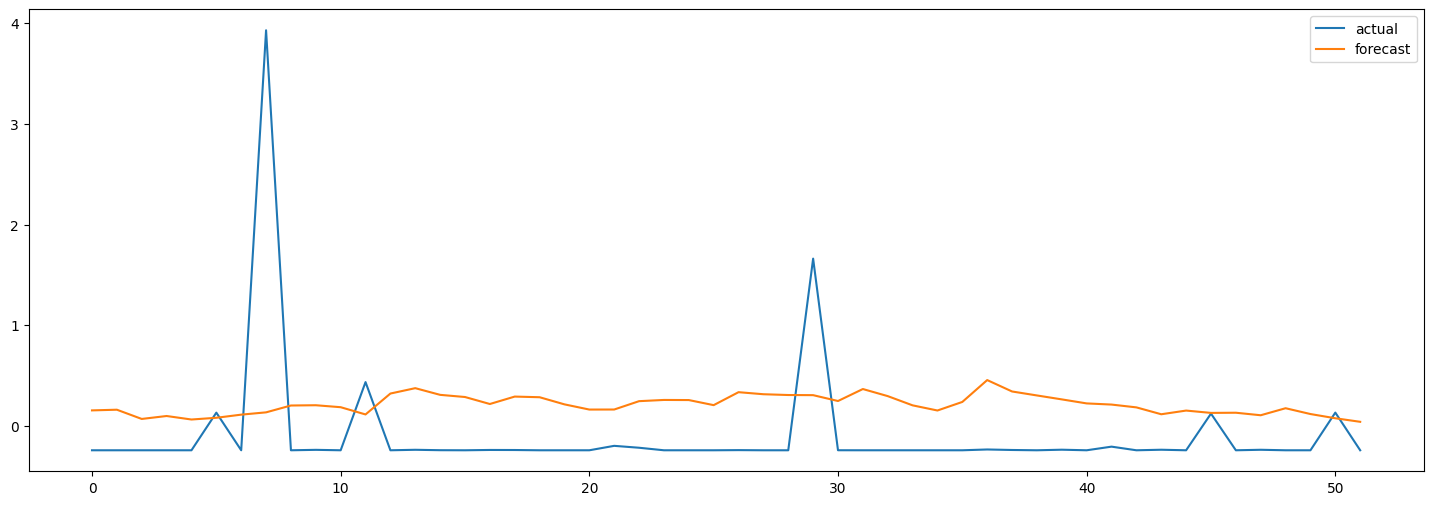

In [339]:
x_test, y = next(area_test_dataset.as_numpy_iterator())
y_pred = model_area.predict(x_test)[:,:,:,0]
print(x_test.shape)
print(y.shape)
print(y_pred.shape)
plt.figure(figsize=(18, 6))
plt.plot(y[:, 0, 0])
plt.plot(y_pred[:, 0, 0])
plt.legend(["actual", "forecast"])

#invert normalized value
area_mean, area_std = features_mean_std[feature_ind]

print(area_std.shape)
x_test = invert_normalization(x_test, area_mean, area_std)
y = invert_normalization(y, area_mean, area_std)
y_pred = invert_normalization(y_pred, area_mean, area_std)

naive_mse, model_mse = (
    np.square(x_test[:, -1, :, 0] - y[:, 0, :]).mean(),
    np.square(y_pred[:, 0, :] - y[:, 0, :]).mean(),
)
naive_mae, model_mae = (
    np.abs(x_test[:, -1, :, 0] - y[:, 0, :]).mean(),
    np.abs(y_pred[:, 0, :] - y[:, 0, :]).mean(),
)
majority_mse, majority_mae = {
    np.square(0 - y[:, 0, feature_ind]).mean(),
    np.abs(0 - y[:, 0, feature_ind]).mean(),
}

print(f"model MSE: {model_mse}, model MAE: {model_mae}")
print(f"naive MSE: {naive_mse}, naive MAE: {naive_mae}")
print(f"Majority MSE: {majority_mse}, Majority MAE: {majority_mae}\n")